In [1]:
# Functions: Analyse the evoltion of average positive and negative
#   triplets = comb(n,3)
#   triangles = glob_transitivity * triplets
import numpy as np
import pandas as pd
import dask.dataframe as dd
import igraph as ig
import matplotlib.pyplot as plt
import time
from fun.fun import *

pd.set_option('display.width', 500)

c:\Users\stirl\miniconda3\envs\network_env\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Filenames
dataset_fn = "../dataset/TweetsCOV19.tsv"
plot_fn = "../images/plots/transitivity_evolution.png"

In [3]:
# -> IN : Read Edge List
edges_fn = "../data/edges.parquet"
print("reading edges ... ", end='')
start = time.time()
df = dd.read_parquet(edges_fn)
df[['source', 'target']] = df[['source', 'target']].astype('int32') # smallest int we can use
end = time.time()
print("read {:_} lines (took {:.1f}s)".format(len(df), (end-start)))
print(df.dtypes)
df

reading edges ... read 684_732_453 lines (took 0.1s)
source    int64
target    int64
dtype: object


,source,target
npartitions=157,,
,int64,int64
,...,...
...,...,...
,...,...
,...,...


In [4]:
# -> IN : Load tweets dataframe
tw = get_filtered_tweets_dataframe(dataset_fn)
print("Loaded {:_} tweets".format(len(tw)))
tw

Importing dataset from tsv file ...read 8_077_794 lines (took 38.3s)
Converting timestamp column
Filtering desired columns and between desired dates ... 8_077_794 rows in dataframe
Parsing hashtags and positive/negative sentiments
filtering for tweets that contain hashtags ... 8_077_794 rows in dataframe
Loaded 462_901 tweets


,Username,Timestamp,Hashtags,Sentiment_pos,Sentiment_neg
Tweet Id,,,,,
1200928806757752833,83c182d0ee195dc692900d7ff7328171,2019-12-01 00:05:14+00:00,"[rgvwx, rgv, txwx, spi]",1,-2
1200931476642115586,73c3e83574f1eb0a5201c71cf46c732c,2019-12-01 00:15:50+00:00,[KeDezembaBoss],2,-4
1200941770835521536,4efca14ff68aa1edd9aea0c78c615ef2,2019-12-01 00:56:45+00:00,"[fame., FreeBritney]",2,-2
1200948819015454721,a53fd620b4178d04a1d2c4e37e85e0ae,2019-12-01 01:24:45+00:00,[FakeNews],1,-2
1200955132944560135,215a5a37e161f7ceaa0c532e73f62c40,2019-12-01 01:49:51+00:00,[KabukiPolitics],1,-1
...,...,...,...,...,...
1233891411109597185,aac81411d4a07a67c96b72655974ed12,2020-02-29 23:06:51+00:00,"[ai, ml, dl]",2,-1
1233896872961552384,4df9baa19ac46918148219d1090740e0,2020-02-29 23:28:33+00:00,"[SKHwy17:, SKHwy3,]",1,-1
1233898288413388807,a19f22a61cd4250367ef67fe2e229f77,2020-02-29 23:34:11+00:00,"[ThinkBIGSundayWithMarsha, SundayThoughts, Sun...",3,-1


In [5]:
# -> IN : Read list of nodes
nodes = pd.read_csv('../data/node_ids.csv', index_col='twitter id')
print("Number of nodes: {:_}".format(len(nodes)))
nodes

Number of nodes: 410_885


,index
twitter id,
1200927495186505729,0
1200927503201816576,1
1200927507828097026,2
1200927511087067136,3
1200927514216062976,4
...,...
1233904468493815808,410880
1233904551159386114,410881
1233904617366392832,410882


In [6]:
# Compute timestamp bins
steps = 100
ts_min, ts_max = min(tw['Timestamp']), max(tw['Timestamp'])
ts_inc = (ts_max - ts_min) / 100
ts_bins = [ ts_min + i*ts_inc for i in range(steps+1) ]

print("Min timestamp:", ts_min)
print("Max timestamp:", ts_max)
print("Timestamp increment:", ts_inc)

Min timestamp: 2019-12-01 00:00:01+00:00
Max timestamp: 2020-02-29 23:59:49+00:00
Timestamp increment: 0 days 21:50:23.880000


In [31]:
# Get transitivity up to each timestamp
transitivity = []

print("  i  STEPS  TIMESTAMP              TWEETS     NODES          EDGES     TRANS      TIME")
for i in range(steps):
    start = time.time()

    window = 10
    lower_i = max(0, i+1-window)
    ts_lower, ts_upper = ts_bins[lower_i], ts_bins[i+1]
    print('{:>3}   {}  {}'.format(i+1, steps, ts_upper.strftime('%Y-%m-%d %X')), end='')

    tw_sel = pd.DataFrame()
    tw_sel['ids'] = np.array( tw[ (ts_lower <= tw['Timestamp']) & (tw['Timestamp'] < ts_upper) ].index ) # get nodes from timestamp range
    print("{:>10_}".format(len(tw_sel)), end='')

    tw_sel['ids'] = tw_sel['ids'].astype('int64')
    tw_sel = tw_sel[tw_sel['ids'].isin(nodes.index)] # filter nodes that are indexed
    tw_sel['index'] = tw_sel['ids'].apply( lambda id: nodes.loc[id]['index'] )
    tw_sel['index'] = tw_sel['index'].astype('int32')

    node_index = { node: index for index, node in enumerate( sorted(tw_sel['index'].tolist()) ) }

    edges = df[ (df['source'].isin(tw_sel['index'])) & (df['target'].isin(tw_sel['index'])) ].compute()
    edges['source_i'] = edges['source'].apply( lambda x: node_index[x] )
    edges['target_i'] = edges['target'].apply( lambda x: node_index[x] )

    g = ig.Graph()
    g.add_vertices(len(node_index))
    g.add_edges( edges[['source_i', 'target_i']].values.tolist() )

    gt = g.transitivity_undirected()
    transitivity.append(gt)

    print("{:>10_}  {:>14_}    {:>4}    {:_}s".format(len(g.vs), len(g.es), round(gt,5), round(time.time()-start,1)))

    #if (i+1)%10 == 0 and input(" Enter 'b' to break ...") == 'b': break

del g
del edges
print("Calculated {} transitivities".format(len(transitivity)))

  i  STEPS  TIMESTAMP              TWEETS     NODES          EDGES     TRANS      TIME
  1   100  2019-12-01 21:50:24     3_693     3_154          35_869    0.91169    11.2s
  2   100  2019-12-02 19:40:48     7_548     6_407          84_227    0.86784    10.6s
  3   100  2019-12-03 17:31:12    11_595     9_794         160_071    0.86322    10.6s
  4   100  2019-12-04 15:21:36    16_204    13_727         299_358    0.85403    10.7s
  5   100  2019-12-05 13:12:00    25_139    22_042      10_092_496    0.98199    44.7s
  6   100  2019-12-06 11:02:24    32_871    29_231      37_500_047    0.98626    224.0s
  7   100  2019-12-07 08:52:48    35_324    31_357      39_498_730    0.98624    232.7s
  8   100  2019-12-08 06:43:12    39_254    34_787      41_704_743    0.98615    252.5s
  9   100  2019-12-09 04:33:35    43_047    38_074      43_406_810    0.98588    265.8s
 10   100  2019-12-10 02:23:59    47_303    41_713      44_690_859    0.98565    293.1s
 11   100  2019-12-11 00:14:23    48_4

In [30]:
tt = pd.DataFrame(data={'transitivity' : transitivity})
tt.to_csv('../data/transitivity/transitivity_window_5.csv', index=False)

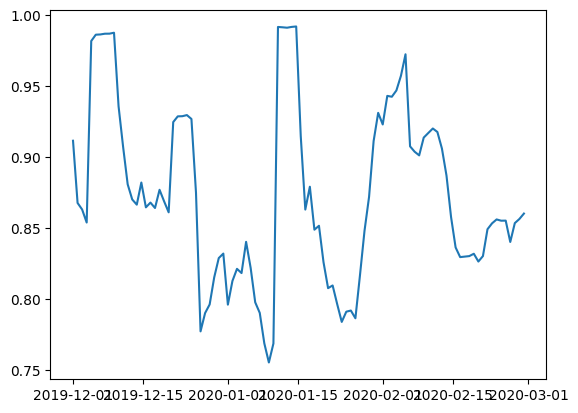

In [27]:
# 
plt.plot(ts_bins[:steps], transitivity)
plt.show()